## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
# !pip install swifter

In [3]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from pprint import pprint
from tqdm import tqdm

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
import swifter


# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

In [5]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [7]:
# Check null/not null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
#Assign new column names
df.rename(columns={'_index':'index',
  '_type':'type',
  '_id':'id',
  '_score':'score',
  '_source.tags':'tags',
  '_source.zip_code':'zipCode',
 '_source.complaint_id':'complaintId',
 '_source.issue':'issue',
 '_source.date_received':'dateReceived',
 '_source.state':'state',
 '_source.consumer_disputed':'consumerDisputed',
 '_source.product':'product',
 '_source.company_response':'companyResponse',
 '_source.company':'company',
 '_source.submitted_via':'submittedVia',
 '_source.date_sent_to_company':'dateSentToCompany',
 '_source.company_public_response':'companyPublicResponse',
 '_source.sub_product':'category',
 '_source.timely':'timely',
 '_source.complaint_what_happened':'complaint',
 '_source.sub_issue':'subIssue',
 '_source.consumer_consent_provided':'consumerConsentProvided'},inplace=True)
df.head()

,index,type,id,score,tags,zipCode,complaintId,issue,dateReceived,state,...,companyResponse,company,submittedVia,dateSentToCompany,companyPublicResponse,category,timely,complaint,subIssue,consumerConsentProvided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [10]:
### As the problem statement is to classify customer complaints based on the products/services so filtering columns here
newDf = df[['complaintId','complaint','product','category']]
newDf

,complaintId,complaint,product,category
0,3211475,,Debt collection,Credit card debt
1,3229299,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,2673060,,Mortgage,Conventional home mortgage
4,3203545,,Credit card or prepaid card,General-purpose credit card or charge card
...,...,...,...,...
78308,3105617,,Checking or savings account,Checking account
78309,3091984,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card
78310,3133355,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account
78311,3110963,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card


In [11]:
### As looking the above data we can see complaint also have some blank values lets do null check
newDf.complaint.isnull().sum()


0

In [12]:
### lets check how many blanks are present as no null values
len(newDf[newDf['complaint']==''])


57241

In [13]:
#Assign nan in place of blanks in the complaints column
newDf[newDf['complaint']==''] = np.nan
newDf.complaint.isnull().sum()

57241

In [14]:
#Remove all rows where complaints column is nan
newDf = newDf[~newDf['complaint'].isnull()]
newDf

,complaintId,complaint,product,category
1,3229299,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
10,3233499,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
11,3180294,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
14,3224980,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account
...,...,...,...,...
78303,3094545,After being a Chase Card customer for well ove...,Credit card or prepaid card,General-purpose credit card or charge card
78309,3091984,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",Credit card or prepaid card,General-purpose credit card or charge card
78310,3133355,I am not familiar with XXXX pay and did not un...,Checking or savings account,Checking account
78311,3110963,I have had flawless credit for 30 yrs. I've ha...,Credit card or prepaid card,General-purpose credit card or charge card


In [15]:
### Check for null count
newDf.complaint.isnull().sum()

0

In [16]:
### lets merge product and category
newDf['product'] = newDf['product'] + '_____' + df['category']
newDf = newDf.drop(['category'],axis= 1)
newDf.head(10)

,complaintId,complaint,product
1,3229299,Good morning my name is XXXX XXXX and I apprec...,Debt collection_____Credit card debt
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card_____General-purpos...
10,3233499,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o..."
11,3180294,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o..."
14,3224980,my grand son give me check for {$1600.00} i de...,Checking or savings account_____Checking account
15,3209411,Can you please remove inquiry,"Credit reporting, credit repair services, or o..."
17,3331023,With out notice J.P. Morgan Chase restricted m...,Checking or savings account_____Checking account
20,3352857,"During the summer months, I experience a decli...",Vehicle loan or lease_____Loan
21,3226110,"On XXXX XX/XX/2019, I made a {$300.00} payment...","Money transfer, virtual currency, or money ser..."
23,3237765,I have a Chase credit card which is incorrectl...,Credit card or prepaid card_____General-purpos...


In [17]:
newDf.complaint.value_counts()

Chase has violated 15 USC 1692 by continuing collection activity after a cease and desist and 15 USC 1681 by failing to report complete and accurate information to credit reporting bureaus.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [18]:
# Write your function here to clean the text and remove all the unnecessary elements.
def textCleanUp(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\{.*\}', '',text).strip() # Remove text in curly braces
    text = re.sub('\(.*\)','', text).strip() # Remove text in small brackets
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub(r'\n', '', text) # Remove line breaks
    text = re.sub(r'x+((/xx)*/\d*\s*)|x*', '',text) #Remove date
    text = re.sub(r'\d+\s', '', text) #Remove other numerical values
    return text.strip()

In [19]:
newDf.complaint = newDf.complaint.apply(lambda x: textCleanUp(x))
newDf

,complaintId,complaint,product
1,3229299,good morning my name is and i appreciate it ...,Debt collection_____Credit card debt
2,3199379,i upgraded my card in and was told by the ag...,Credit card or prepaid card_____General-purpos...
10,3233499,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o..."
11,3180294,on while trying to book a ticket i came ac...,"Credit reporting, credit repair services, or o..."
14,3224980,my grand son give me check for i deposit it i...,Checking or savings account_____Checking account
...,...,...,...
78303,3094545,after being a chase card customer for well ove...,Credit card or prepaid card_____General-purpos...
78309,3091984,on wednesday i called chas my visa credit c...,Credit card or prepaid card_____General-purpos...
78310,3133355,i am not familiar with pay and did not unders...,Checking or savings account_____Checking account
78311,3110963,i have had flawless credit for yrs ive had cha...,Credit card or prepaid card_____General-purpos...


In [20]:
#Write your function to Lemmatize the texts

stopwords = nlp.Defaults.stop_words
def lemmatization(text):
    data = nlp(text)
    sent = [token.lemma_ for token in data if not token.text in set(stopwords)]
    return ' '.join(sent)


In [21]:
import time

start = time.time()
newDf['lemma'] =  newDf.complaint.swifter.apply(lambda x: lemmatization(x))

end = time.time()
print("Time Taken: ",end - start)

newDf.head(10)


Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Time Taken:  947.7227942943573


,complaintId,complaint,product,lemma
1,3229299,good morning my name is and i appreciate it ...,Debt collection_____Credit card debt,good morning appreciate help stop chase ban...
2,3199379,i upgraded my card in and was told by the ag...,Credit card or prepaid card_____General-purpos...,upgrade card tell agent upgrade anniversary...
10,3233499,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",chase card report fraudulent application submi...
11,3180294,on while trying to book a ticket i came ac...,"Credit reporting, credit repair services, or o...",try book ticket come offer apply ticket...
14,3224980,my grand son give me check for i deposit it i...,Checking or savings account_____Checking account,grand son check deposit chase account fund c...
15,3209411,can you please remove inquiry,"Credit reporting, credit repair services, or o...",remove inquiry
17,3331023,with out notice jp morgan chase restricted my ...,Checking or savings account_____Checking account,notice jp morgan chase restrict account debit ...
20,3352857,during the summer months i eperience a decline...,Vehicle loan or lease_____Loan,summer month eperience decline income employme...
21,3226110,on i made a payment to an online retailer us...,"Money transfer, virtual currency, or money ser...",payment online retailer chase quick pay ...
23,3237765,i have a chase credit card which is incorrectl...,Credit card or prepaid card_____General-purpos...,chase credit card incorrectly report datum cre...


In [22]:
newDf.shape

(21072, 4)

In [23]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'complaints':newDf['complaint'], 'lemmatized':newDf['lemma']})


In [24]:
df_clean

,complaints,lemmatized
1,good morning my name is and i appreciate it ...,good morning appreciate help stop chase ban...
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...
78309,on wednesday i called chas my visa credit c...,wednesday call chas visa credit card prov...
78310,i am not familiar with pay and did not unders...,familiar pay understand great risk provide c...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...


In [25]:
#Write your function to extract the POS tags 

def posTags(text):
  # write your code here
    nn_words = []
    data = nlp(text)
    sent = [token.text for token in data if token.tag_ == 'NN']
    return ' '.join(sent)


df_clean["complaint_POS_removed"] =  df_clean.lemmatized.swifter.apply(lambda x: posTags(x), axis=1)



Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized,complaint_POS_removed
1,good morning my name is and i appreciate it ...,good morning appreciate help stop chase ban...,morning help bank service write chase debt ver...
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...,book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit c...,wednesday call chas visa credit card prov...,call visa credit card provider ask claim purch...
78310,i am not familiar with pay and did not unders...,familiar pay understand great risk provide c...,pay risk consumer year trust mobile banking te...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




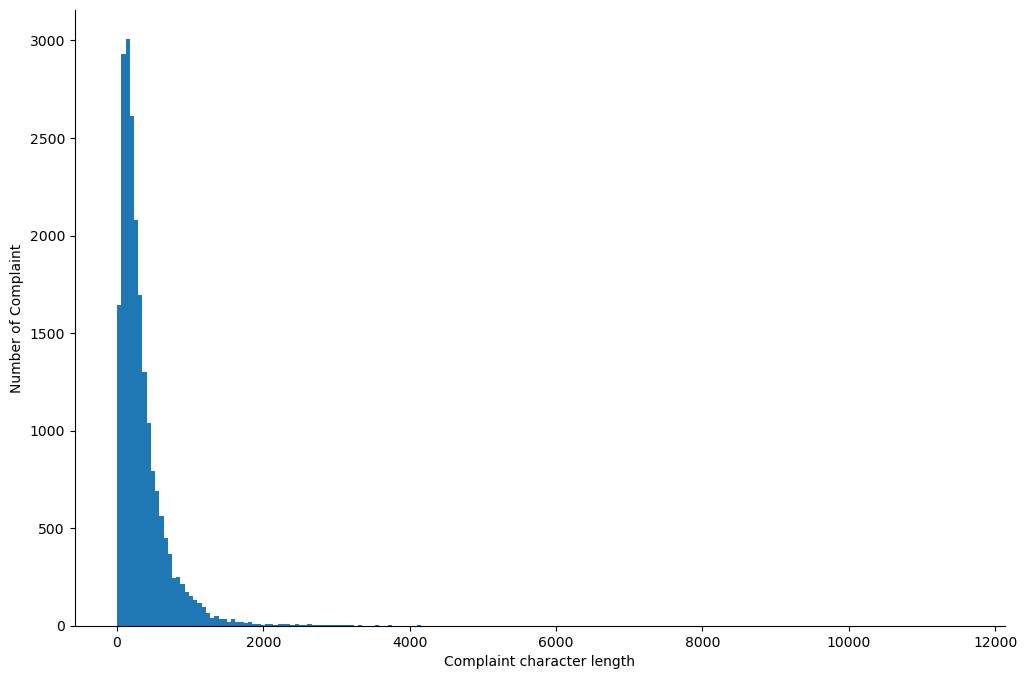

In [27]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(12,8))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 200)
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
sns.despine();

#### Find the top 40 words by frequency among all the articles after processing the text.

In [28]:
### install wordcloud if not present
!pip install wordcloud

In [29]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud


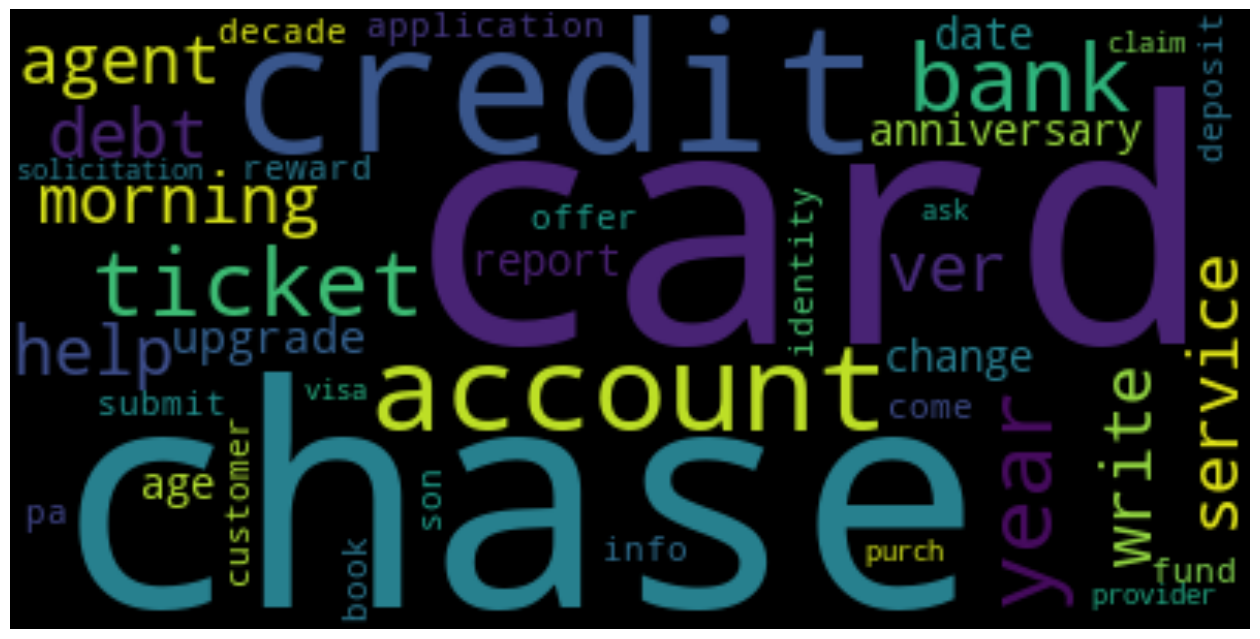

In [30]:

wordcloud = WordCloud(max_words=40, random_state=1, stopwords=stopwords)
wordcloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [31]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')


In [32]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is and i appreciate it ...,good morning appreciate help stop chase ban...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday i called chas my visa credit c...,wednesday call chas visa credit card prov...,call visa credit card provider ask claim purch...,call visa credit card provider ask claim purch...
78310,i am not familiar with pay and did not unders...,familiar pay understand great risk provide c...,pay risk consumer year trust mobile banking te...,pay risk consumer year trust mobile banking te...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
### method to find n grams
def getTopNGrams(text, ngram, fixedRows, columnName):
    
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    df_ngram = pd.DataFrame(words_freq).rename(columns={0: 'frequency', 1: columnName})
    pd.set_option('display.max_rows', fixedRows)
    return df_ngram.head(fixedRows)


In [34]:
def plotChart(x,y):
    plt.figure(figsize=(12,8))
    fig = sns.barplot(y=y, x=x)
    plt.xticks(rotation = 90)
    plt.show()

In [35]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def getTop30UniGrams():
    top30UniGrams = getTopNGrams(df_clean.complaints, 1, 30, "unigram")
    return top30UniGrams

In [36]:
#Print the top 10 words in the unigram frequency
unigrams = getTop30UniGrams()
top10Unigrams = unigrams.head(10)
top10Unigrams

,frequency,unigram
0,chase,67895
1,account,34857
2,credit,28212
3,bank,22813
4,card,22393
5,told,13175
6,did,13123
7,payment,11079
8,called,10889
9,received,10563


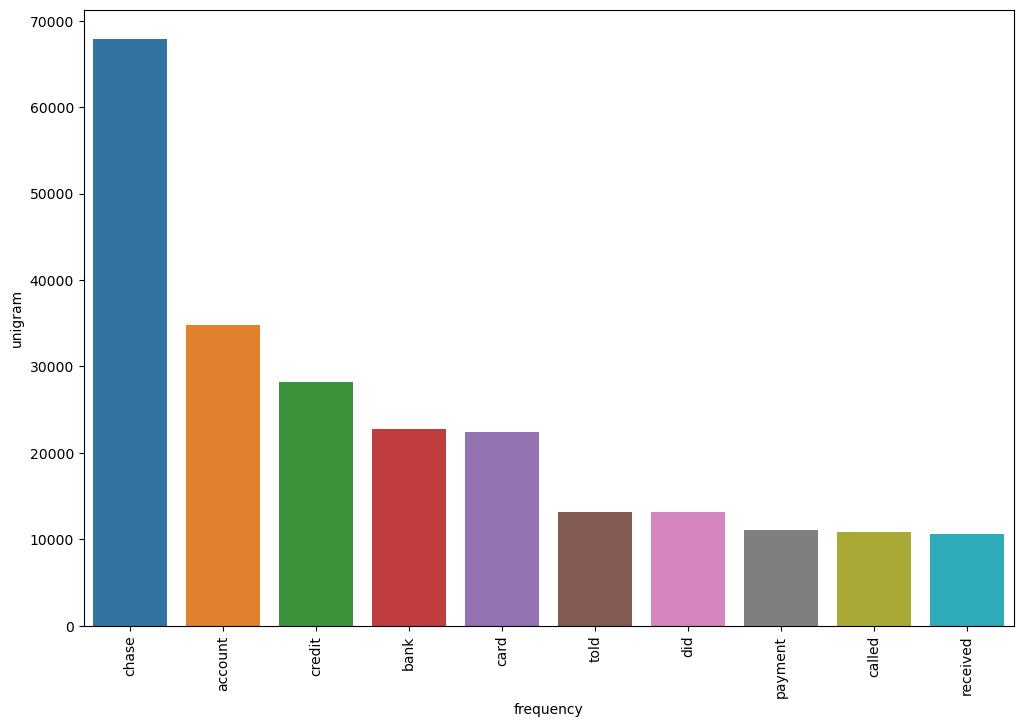

In [37]:
plotChart(x=top10Unigrams['frequency'],y=top10Unigrams['unigram'])

In [38]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def getTop30BiGrams():
    top30BiGrams = getTopNGrams(df_clean.complaints, 2, 30, "bigram")
    return top30BiGrams

In [39]:
#Print the top 10 words in the bigram frequency
bigrams = getTop30BiGrams()
top10BiGrams = bigrams.head(10)
top10BiGrams

,frequency,bigram
0,chase bank,11083
1,credit card,9403
2,credit report,2996
3,called chase,2995
4,checking account,2770
5,customer service,2501
6,jp morgan,2495
7,chase credit,2252
8,morgan chase,2159
9,account chase,1834


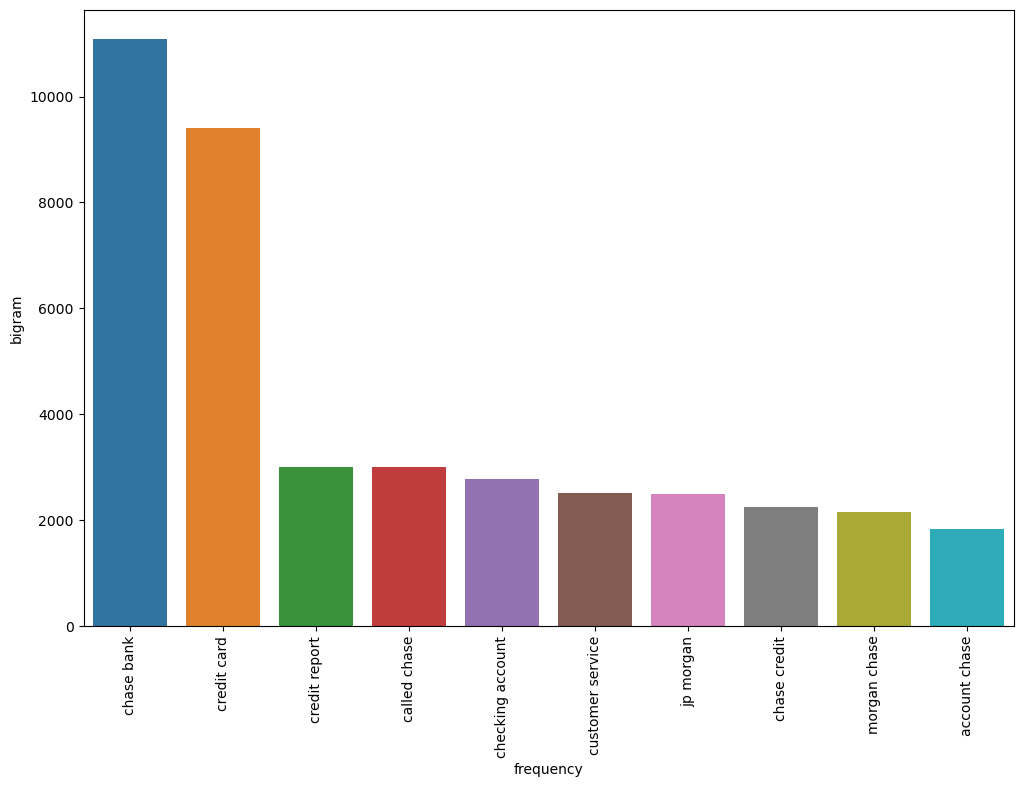

In [40]:
plotChart(x=top10BiGrams['frequency'],y=top10BiGrams['bigram'])

In [41]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def getTop30TriGrams():
    top30BiGrams = getTopNGrams(df_clean.complaints, 3, 30, "trigram")
    return top30BiGrams

In [42]:
#Print the top 10 words in the trigram frequency
triGrams = getTop30TriGrams()
top10TriGrams = triGrams.head(10)
top10TriGrams

,frequency,trigram
0,jp morgan chase,2058
1,chase credit card,1726
2,credit card company,656
3,morgan chase bank,601
4,credit card account,597
5,credit card chase,525
6,account chase bank,503
7,chase customer service,453
8,received letter chase,413
9,called chase bank,362


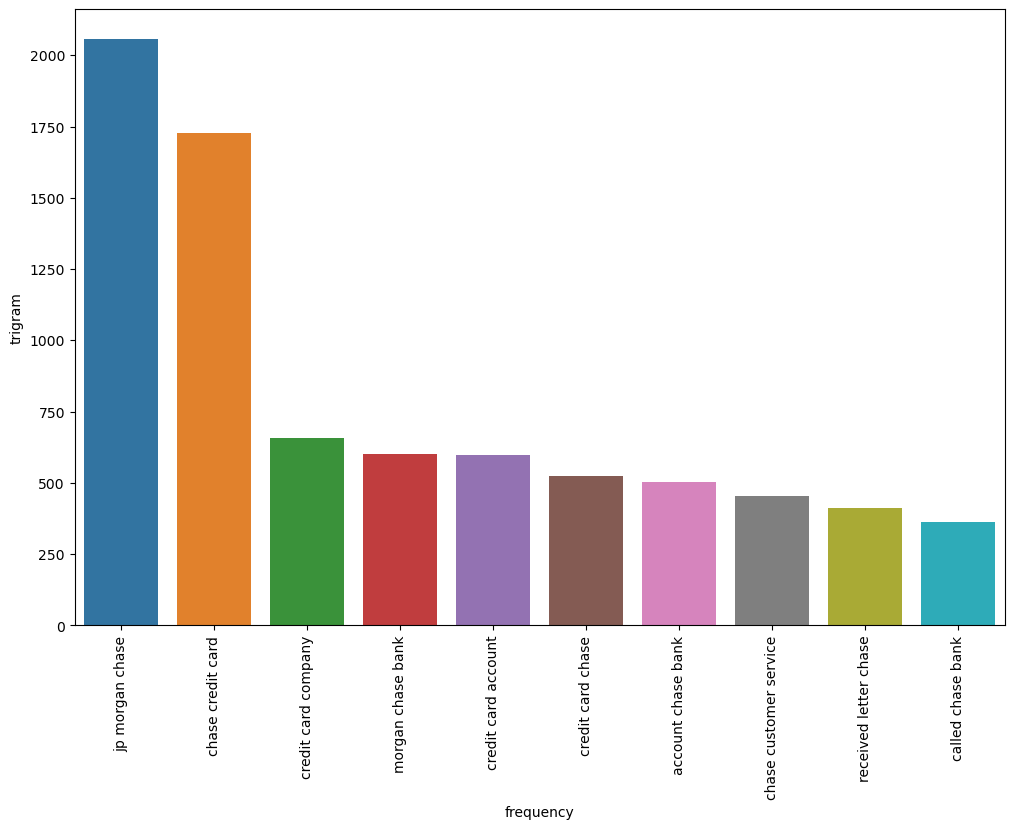

In [43]:
plotChart(x=top10TriGrams['frequency'],y=top10TriGrams['trigram'])

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [44]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [45]:
#All masked texts has been removed
df_clean.shape

(21072, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [46]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [47]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaints'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [48]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [49]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(random_state=40, n_components=num_topics)

In [50]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

14683

In [51]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names_out())
topic_words_df = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)

for i in range(num_topics):
    ix = nmf_model.components_[i].argsort()[::-1][:15]
    topic_words_df.iloc[i] = words[ix]

topic_words_df

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,chase,card,charges,charge,dispute,called,fraud,received,did,told,claim,transaction,merchant,said,refund
Topic 2,credit,card,report,inquiry,chase,hard,inquiries,cards,reporting,score,accounts,account,applied,removed,closed
Topic 3,loan,mortgage,chase,home,modification,property,foreclosure,payments,bank,morgan,jp,house,sale,years,rate
Topic 4,account,bank,check,chase,money,funds,closed,checking,deposit,branch,accounts,told,deposited,business,open
Topic 5,payment,late,payments,balance,paid,pay,month,fees,fee,statement,make,monthly,auto,days,chase


In [52]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
bestTopic = nmf_model.transform(dtm)
bestTopic.argmax(axis=1)


array([2, 0, 1, ..., 0, 1, 4], dtype=int64)

In [53]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = bestTopic.argmax(axis=1)

In [54]:
df_clean.head()

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning appreciate help stop chase ban...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,2
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...,1
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,3


In [55]:
df_clean.shape

(21072, 5)

In [56]:
#Print the first 5 Complaint for each of the Topics
dfTop5=df_clean.groupby('Topic').head(5)
dfTop5.sort_values('Topic')

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,0
21,on i made a payment to an online retailer us...,payment online retailer chase quick pay ...,retailer chase pay chase website scam website ...,retailer chase pay chase website scam website ...,0
43,chase sent me an email today with the innocuou...,chase send email today innocuous title impor...,chase email today title information change cha...,chase email today title information change cha...,0
40,a sofa love seat table and chairs and was neve...,sofa love seat table chair deliver debit card ...,love seat table chair deliver debit card charg...,love seat table chair deliver debit card charg...,0
32,my chase amazon card was declined for a cateri...,chase amazon card decline catering order place...,catering order place brother funeral transacti...,catering order place brother funeral transacti...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...,1
15,can you please remove inquiry,remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,chase credit card incorrectly report datum cre...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1
26,i have reached out to several times in attemp...,reach time attempt fraudulent inquiry remove...,time attempt inquiry remove need contact credi...,time attempt inquiry remove need contact credi...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [57]:
# Create the dictionary of Topic names and Topics
Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}

# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [58]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning appreciate help stop chase ban...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,Mortgage/Loan
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,Account Services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,Others
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...,Others
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,Credit card or prepaid card
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Others
78309,on wednesday i called chas my visa credit c...,wednesday call chas visa credit card prov...,call visa credit card provider ask claim purch...,call visa credit card provider ask claim purch...,Account Services
78310,i am not familiar with pay and did not unders...,familiar pay understand great risk provide c...,pay risk consumer year trust mobile banking te...,pay risk consumer year trust mobile banking te...,Account Services
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [59]:
#Create the dictionary again of Topic names and Topics

Topic_names = {'Account Services':0, 'Others':1, 'Mortgage/Loan':2, 'Credit card or prepaid card':3, 'Theft/Dispute Reporting':4}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [60]:
df_clean

,complaints,lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is and i appreciate it ...,good morning appreciate help stop chase ban...,morning help bank service write chase debt ver...,morning help bank service write chase debt ver...,2
2,i upgraded my card in and was told by the ag...,upgrade card tell agent upgrade anniversary...,card agent upgrade anniversary date change age...,card agent upgrade anniversary date change age...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a ticket i came ac...,try book ticket come offer apply ticket...,book ticket come offer ticket reward card info...,book ticket come offer ticket reward card info...,1
14,my grand son give me check for i deposit it i...,grand son check deposit chase account fund c...,son deposit chase account fund bank account pa...,son deposit chase account fund bank account pa...,3
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday i called chas my visa credit c...,wednesday call chas visa credit card prov...,call visa credit card provider ask claim purch...,call visa credit card provider ask claim purch...,0
78310,i am not familiar with pay and did not unders...,familiar pay understand great risk provide c...,pay risk consumer year trust mobile banking te...,pay risk consumer year trust mobile banking te...,0
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit yrs credit card chase freedom problem t...,credit yrs credit card chase freedom problem t...,1


In [61]:
# Plot graph to check topic details
# plt.figure(figsize=(12,8))
# sns.countplot(x='Topic',data=df_clean.value_counts())
df_clean.shape

(21072, 5)

In [62]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaints','Topic']]

In [63]:
training_data

,complaints,Topic
1,good morning my name is and i appreciate it ...,2
2,i upgraded my card in and was told by the ag...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a ticket i came ac...,1
14,my grand son give me check for i deposit it i...,3
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday i called chas my visa credit c...,0
78310,i am not familiar with pay and did not unders...,0
78311,i have had flawless credit for yrs ive had cha...,1


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [64]:
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data.complaints)

# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


 models on the train & test data for below options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [65]:
# Write your code here to build any 3 models and evaluate them using the required metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report

In [66]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.2, random_state=42)


In [67]:
# Logistic Regression
lr = LogisticRegression().fit(X_train, y_train)
predicted = lr.predict(X_test)

print(classification_report(y_true=y_test, y_pred=predicted))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       965
           1       0.96      0.95      0.95       945
           2       0.98      0.94      0.96       713
           3       0.94      0.97      0.95      1114
           4       0.96      0.89      0.93       478

    accuracy                           0.95      4215
   macro avg       0.95      0.94      0.95      4215
weighted avg       0.95      0.95      0.95      4215



In [68]:
# Decision tree 
dt = DecisionTreeClassifier().fit(X_train, y_train)
predicted = dt.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       965
           1       0.82      0.80      0.81       945
           2       0.80      0.80      0.80       713
           3       0.79      0.80      0.79      1114
           4       0.70      0.69      0.69       478

    accuracy                           0.77      4215
   macro avg       0.76      0.76      0.76      4215
weighted avg       0.77      0.77      0.77      4215



In [69]:
# Random Forest
rfc = RandomForestClassifier(max_depth=10)
rfc.fit(X_train, y_train)
predicted = rfc.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.78      0.66      0.72       965
           1       0.80      0.77      0.79       945
           2       0.88      0.78      0.82       713
           3       0.59      0.97      0.73      1114
           4       1.00      0.02      0.04       478

    accuracy                           0.71      4215
   macro avg       0.81      0.64      0.62      4215
weighted avg       0.78      0.71      0.68      4215



In [71]:
# Naive Bayes
nb = GaussianNB().fit(X_train.toarray(), y_train)
predicted = nb.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38       965
           1       0.37      0.30      0.33       945
           2       0.51      0.44      0.47       713
           3       0.44      0.29      0.35      1114
           4       0.17      0.53      0.26       478

    accuracy                           0.35      4215
   macro avg       0.39      0.38      0.36      4215
weighted avg       0.41      0.35      0.36      4215



###  Logistic Regression is performing better


##### Concluding the best model with custom text performance


In [75]:
### Sample taken few from above, few random
df_complaints = pd.DataFrame({'complaints': ["I did that to close out my account roughly {$500.00} payment when I closed out the accounts, and now I get this late payment that showed up on my credit report after 10+ years stating I owe close to {$900.00} dollars",
                                             "I called the number on the letter and was told that Chase had decided to close the accounts with no reason given",
                                             "I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "What is the procedure to know my CIBIL score?",
                                            "I am a victim of identity theft"]})
df_complaints

,complaints
0,I did that to close out my account roughly {$5...
1,I called the number on the letter and was told...
2,I can not get from chase who services my mortg...
3,The bill amount of my credit card was debited ...
4,I want to open a salary account at your downto...
5,What is the procedure to know my CIBIL score?
6,I am a victim of identity theft


In [76]:
def predict_lr(text):
    Topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vect.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = lr.predict(X_new_tfidf)
    return Topic_names[predicted[0]]

In [77]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_lr([x]))
df_complaints

,complaints,tag
0,I did that to close out my account roughly {$5...,Theft/Dispute Reporting
1,I called the number on the letter and was told...,Credit card or prepaid card
2,I can not get from chase who services my mortg...,Mortgage/Loan
3,The bill amount of my credit card was debited ...,Others
4,I want to open a salary account at your downto...,Credit card or prepaid card
5,What is the procedure to know my CIBIL score?,Mortgage/Loan
6,I am a victim of identity theft,Others
